In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Sequential
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
x, t = load_iris(return_X_y=True)
print('x:', x.shape)
print('t:', t.shape)

x: (150, 4)
t: (150,)


In [3]:
x = x.astype('float32')
t = t.astype('int32')

In [4]:
x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

In [5]:
l = L.Linear(4, 3)

In [6]:
n_input = 4
n_hidden = 10
n_output = 3

net = Sequential(
L.Linear(n_input, n_hidden), F.relu,
L.Linear(n_hidden, n_hidden), F.relu,    
L.Linear(n_hidden, n_output)
)

In [7]:
optimizer = chainer.optimizers.SGD(lr=0.01)
optimizer = optimizer.setup(net)

In [8]:
n_epoch = 30
n_batchsize = 16

In [9]:
iteration = 0

results_train = {
    'loss':[],
    'accuracy':[]
}

results_valid = {
    'loss':[],
    'accuracy':[]
}

for epoch in range(n_epoch):
    order = np.random.permutation(range(len(x_train)))
    
    loss_list = []
    accuracy_list = []
    
    for i in range(0, len(order), n_batchsize):
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]
        
        y_train_batch = net(x_train_batch)
        
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)
        
        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)
        
        net.cleargrads()
        loss_train_batch.backward()
        
        optimizer.update()
        
        iteration += 1
        
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(epoch, iteration, loss_train, loss_val.array))

    results_train['loss'].append(loss_train)
    results_train['accuracy'].append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 5, loss (train): 1.0761, loss (valid): 1.1050
epoch: 1, iteration: 10, loss (train): 1.0613, loss (valid): 1.0889
epoch: 2, iteration: 15, loss (train): 1.0433, loss (valid): 1.0756
epoch: 3, iteration: 20, loss (train): 1.0325, loss (valid): 1.0611
epoch: 4, iteration: 25, loss (train): 1.0187, loss (valid): 1.0468
epoch: 5, iteration: 30, loss (train): 1.0051, loss (valid): 1.0362
epoch: 6, iteration: 35, loss (train): 0.9935, loss (valid): 1.0256
epoch: 7, iteration: 40, loss (train): 0.9875, loss (valid): 1.0128
epoch: 8, iteration: 45, loss (train): 0.9711, loss (valid): 0.9980
epoch: 9, iteration: 50, loss (train): 0.9591, loss (valid): 0.9864
epoch: 10, iteration: 55, loss (train): 0.9594, loss (valid): 0.9686
epoch: 11, iteration: 60, loss (train): 0.9358, loss (valid): 0.9521
epoch: 12, iteration: 65, loss (train): 0.9245, loss (valid): 0.9368
epoch: 13, iteration: 70, loss (train): 0.9083, loss (valid): 0.9197
epoch: 14, iteration: 75, loss (train): 0.888

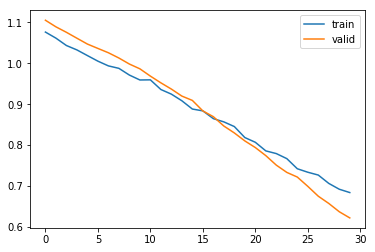

In [10]:
plt.plot(results_train['loss'], label='train')
plt.plot(results_valid['loss'], label='valid')
plt.legend()

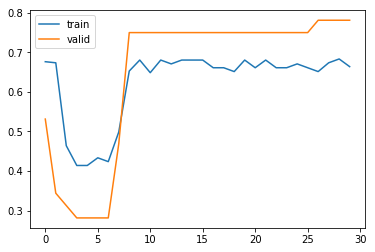

In [11]:
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  

In [12]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)

In [13]:
accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.6, dtype=float32)

In [14]:
loaded_net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [15]:
chainer.serializers.load_npz('my_iris.net', loaded_net)

In [16]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = loaded_net(x_test)

In [17]:
np.argmax(y_test[0,:].array)

2